In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from einops.layers.torch import Rearrange

#신경망 구현에 사용될 helper 함수와 클래스들 정의
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# Upsample function
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )

# Downsample function
def Downsample(dim, dim_out=None):
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


In [ ]:
# 신경망의 parameter가 time(noise level)간에 공유되기 때문에, t를 encoding하기 위해서, sinusoidal position embeddings를 사용
# position embeddings는 신경망이 batch의 모든 이미지에 대해서 어느 특정 time step(noise level)이 진행되고 있는지 "알도록" 한다. -> 모델이 학습 시 각 이미지가 어떤 노이즈 레벨에 있는지 알 수 있도록 합니다.
# SinusoidalPositionEmbeddings 모듈은 (batch_size, 1) shape의 tensor를 입력으로 받고 (i.e. batch 안의 여러 noisy image들의 noise levels), (batch_size, dim) shape의 tensor를 출력한다.

import torch
import torch.nn as nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [ ]:
# ResBet block
# U-Net 모델의 핵심 building block을 정의
# "weight standardized" 버전의 standard convolution layer로 대체함. 이 대체한 버전이 group normalization과 조합했을 때 더 잘 동작한다는 부분 확인.

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from functools import partial
from einops import reduce

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


# ResNet Block
class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


In [ ]:
#Attention module
#두 가지 Attention 모듈 구현. 하나는 Multi-Head Self-Attention이고, 다른 하나는 Linear Attention으로, Diffusion 모델의 메모리 사용량을 줄이기 위해 설계.

import torch
import torch.nn as nn
from einops import rearrange
from torch import einsum

# Multi-Head Self-Attention Module
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

# Linear Attention Module
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = einsum("b h d n, b h e n -> b h d e", k, v)

        out = einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)




In [ ]:
# 신경망 정의 - Conditional U-Net

import torch
import torch.nn as nn
from functools import partial

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = init_dim or dim
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # Time embeddings
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # Downsample layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                    ]
                )
            )

        # Mid blocks
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        # Upsample layers
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                    ]
                )
            )

        self.out_dim = out_dim or channels
        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = x_self_cond if x_self_cond is not None else torch.zeros_like(x)
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        # Downsample path
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        # Mid layers
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # Upsample path
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)



In [ ]:
#Forward Diffusion Process 정의
#forward process는 real distribution에서 뽑은 image에 점진적으로 noise를 추가한다. 이때, time steps T만큼 진행된다.
#이 과정은 variance schedule에 따라 진행된다.
#consie schedule 사용하는게 결과 더 좋음.

import torch

# Cosine Beta Schedule
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start



In [ ]:
# T=300 time steps 동안 linear schedule을 사용

import torch
import torch.nn.functional as F

timesteps = 300

betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [ ]:
#실제로 noise는 Pillow 이미지들에 추가되는 것이 아니라, PyTorch tensor에 추가된다.
#따라서 PIL image를 PyTorch tensor로 변환하는 image transformation들을 정의하고,
#역시 PyTorch tensor를 PIL image로 변환하는 image transformation들도 정의한다.

from PIL import Image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

x_start = transform(image).unsqueeze(0)
print(x_start.shape)

reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2),
    ToPILImage(),
])

image_reconstructed = reverse_transform(x_start.squeeze(0))
image_reconstructed.show()


torch.Size([1, 3, 128, 128])


In [ ]:
# Pytorch tensor ➡️ PIL image
# [-1, 1] 사이의 값들을 포함하는 Pytorch tensor를 PIL image로 다시 변환하는 변환을 정의한다.
from torchvision.transforms import Compose, Lambda, ToPILImage

reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2),
    Lambda(lambda t: t.clamp(0, 1)),
    ToPILImage(),
])


In [ ]:
#forward diffusion process를 정의

import torch

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


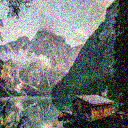

In [ ]:
# 특정 time step에 대해서 test해보기

def get_noisy_image(x_start, t):

    x_noisy = q_sample(x_start, t=t)
    noisy_image = reverse_transform(x_noisy.squeeze(0))

    return noisy_image

t = torch.tensor([40])
get_noisy_image(x_start, t)


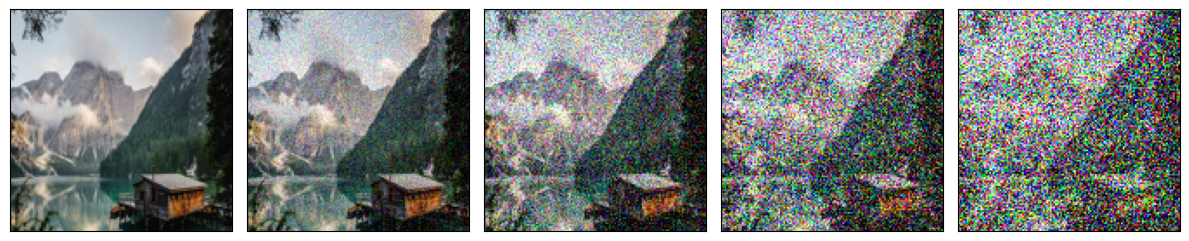

In [ ]:
#더 다양한 time step의 결과를 시각화

import matplotlib.pyplot as plt
import numpy as np
import torch

torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(12, 12), nrows=num_rows, ncols=num_cols, squeeze=False)

    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    plt.show()

plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 20, 50, 100, 150]])


In [ ]:
#Loss function 정의
#denoise_model은 우리가 정의한 U-Net 신경망

import torch
import torch.nn.functional as F

# Loss function definition
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

    return loss


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import kagglehub
import os

# Kaggle 데이터셋 다운로드
path1 = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("Path to dataset files:", path1)

# 이미지 설정
image_size = 128
channels = 3
batch_size = 16

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 사용자 정의 Dataset 클래스
class LandscapeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0

# 데이터셋 로드 (1000개 이미지 제한)
dataset = LandscapeDataset(root_dir=path1, transform=transform)

# DataLoader 정의
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

images, labels = next(iter(dataloader))
print(images.shape)

Path to dataset files: /root/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2
torch.Size([16, 3, 128, 128])


In [ ]:
#!pip install  datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#model을 training하는 동안에 sampling 하기 위한 코드를 정의

@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)

        return model_mean + torch.sqrt(posterior_variance_t) * noise


In [ ]:

import torch
from tqdm import tqdm

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())

    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [ ]:
#Train the Model 생성된 이미지를 저장하기 위한 로직
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)
save_and_sample_every = 1000


In [ ]:
import torch
import torch.nn as nn

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.GroupNorm(1, dim)
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)


In [ ]:
import torch
from torch.optim import Adam

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4)
)
model.to(device)

# Define optimizer
optimizer = Adam(model.parameters(), lr=1e-3)



In [ ]:
from torchvision.utils import save_image

epochs = 150

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch[0].shape[0]
        batch = batch[0].to(device)

        # Algorithm 1
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        # 손실값 계산
        loss = p_losses(denoise_model=model, x_start=batch, t=t, loss_type="huber")

        if step % 100 == 0:
            print("Epoch:", epoch, "Step:", step, "Loss:", loss.item())


        loss.backward()
        optimizer.step()

        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(num=4, divisor=batch_size)
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5  # Normalize images to [0, 1] range
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow=6)



Epoch: 0 Step: 0 Loss: 0.5461959838867188
Epoch: 0 Step: 100 Loss: 0.12799303233623505
Epoch: 0 Step: 200 Loss: 0.10810496658086777
Epoch: 1 Step: 0 Loss: 0.08714865148067474
Epoch: 1 Step: 100 Loss: 0.03228740394115448
Epoch: 1 Step: 200 Loss: 0.02728528156876564
Epoch: 2 Step: 0 Loss: 0.034126557409763336
Epoch: 2 Step: 100 Loss: 0.024719513952732086
Epoch: 2 Step: 200 Loss: 0.037980817258358
Epoch: 3 Step: 0 Loss: 0.030993402004241943
Epoch: 3 Step: 100 Loss: 0.03039967082440853
Epoch: 3 Step: 200 Loss: 0.07225580513477325
Epoch: 4 Step: 0 Loss: 0.04176710173487663
Epoch: 4 Step: 100 Loss: 0.02135145664215088
Epoch: 4 Step: 200 Loss: 0.022332947701215744
Epoch: 5 Step: 0 Loss: 0.06071258336305618
Epoch: 5 Step: 100 Loss: 0.03234487026929855
Epoch: 5 Step: 200 Loss: 0.03390752896666527
Epoch: 6 Step: 0 Loss: 0.01537301391363144
Epoch: 6 Step: 100 Loss: 0.03285755589604378
Epoch: 6 Step: 200 Loss: 0.05162492394447327
Epoch: 7 Step: 0 Loss: 0.04180905222892761
Epoch: 7 Step: 100 Loss: 

sampling loop time step: 100%|██████████| 300/300 [02:50<00:00,  1.76it/s]


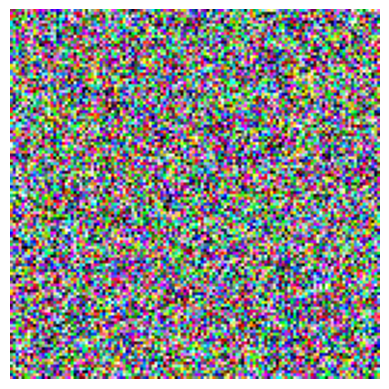

In [ ]:
import matplotlib.pyplot as plt
import torch

# 샘플 이미지 64개 생성
samples = sample(model, image_size=image_size, batch_size=16, channels=channels)

# 텐서로 병합
samples = torch.cat([torch.tensor(sample) for sample in samples], dim=0)

# 생성된 이미지의 값 범위 정규화
samples = (samples + 1) * 0.5
samples = torch.clamp(samples, 0, 1)

samples_np = samples.permute(0, 2, 3, 1).cpu().numpy()

# 랜덤으로 하나의 이미지 출력
random_index = 53
plt.imshow(samples_np[random_index].squeeze(), cmap="gray")
plt.axis('off')
plt.show()


## 결론 : 노이즈값만 반환되는 부분 확인. GPU 한계로 이미지 수를 1000개로 제한하여 학습시킨 것이 문제라고 판단. 코랩 프로 플러스 계정으로 진행했는데도 GPU 문제가 보여졌기 때문에 직접학습은 불가하다 판단함. Stable diffusion 오픈모델을 불러와서 파인튜닝 진행하기로 함.
